In [1]:
import FewShotCVRP.examples.analysis.ea_stats_store as ea_stats
from importlib import reload


reload(ea_stats)

_st = ea_stats.EAStatsStore()
_st.load_raw("ea_runs/raw_runs.parquet")
_st.compute_stats()

ans = _st.summarize(print_output=True)

/data/antonovk/FewShotCVRP/FewShotCVRP/examples/analysis/ea_stats_store.py:368: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged = pd.concat([self._raw, df_new], ignore_index=True)



=== Summary by (algorithm_name, cvrp_instance_name, nn_training_method, nn_trained_on_instance) ===
       algorithm_name cvrp_instance_name nn_training_method nn_trained_on_instance  n_runs  total_rows  rows_per_run_mean  rows_per_run_std  rows_per_run_min  rows_per_run_max
              descent     X-n101-k25.xml                NaN                    NaN     100        5100               51.0               0.0                51                51
              descent     X-n209-k16.xml                NaN                    NaN     100        5100               51.0               0.0                51                51
              descent     X-n219-k73.xml                NaN                    NaN     100        5100               51.0               0.0                51                51
              descent     X-n367-k17.xml                NaN                    NaN     100        5100               51.0               0.0                51                51
              desce

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns

import FewShotCVRP.utils.plots as myplots

myplots.good_plt_config()

# ColorBrewer Set2 (8-color qualitative palette)
SET2_8 = [
    "#66C2A5",
    "#FC8D62",
    "#8DA0CB",
    "#E78AC3",
    "#A6D854",
    "#FFD92F",
    "#E5C494",
    "#B3B3B3",
]

DEFAULT_MPL_COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]


def get_finals(instance_name, algorithm_name):
    return _st._raw.loc[
        (_st._raw["algorithm_name"] == algorithm_name)
        & (_st._raw["cvrp_instance_name"] == instance_name)
        & (_st._raw["evals"] == 1000001),
        "best_so_far",
    ].to_numpy()


=== Welch t-tests per instance (Bonferroni-corrected) ===
       instance    mean_A    mean_B       std_A       std_B         t        p  cohens_d_(A_minus_B)   p_bonf  reject@Bonferroni=0.05
 X-n101-k25.xml  30444.15  30520.84  387.354831  402.165470 -1.373454 0.171167             -0.194236 1.000000                   False
 X-n209-k16.xml  53198.69  53000.99 1063.568975 1167.976585  1.251529 0.212231              0.176993 1.000000                   False
 X-n641-k35.xml 206961.19 207259.82 2724.221977 2475.917287 -0.951956 0.342184             -0.112933 1.000000                   False
 X-n219-k73.xml 132627.80 132454.60 1045.858972  867.784210  1.274470 0.204041              0.180237 1.000000                   False
 X-n367-k17.xml  66500.67  66356.03 1066.925821 1037.089648  0.972100 0.332188              0.137476 1.000000                   False
 X-n480-k70.xml 163462.43 163452.87 1823.934997 1852.935005  0.036769 0.970706              0.005200 1.000000                   False
X-n

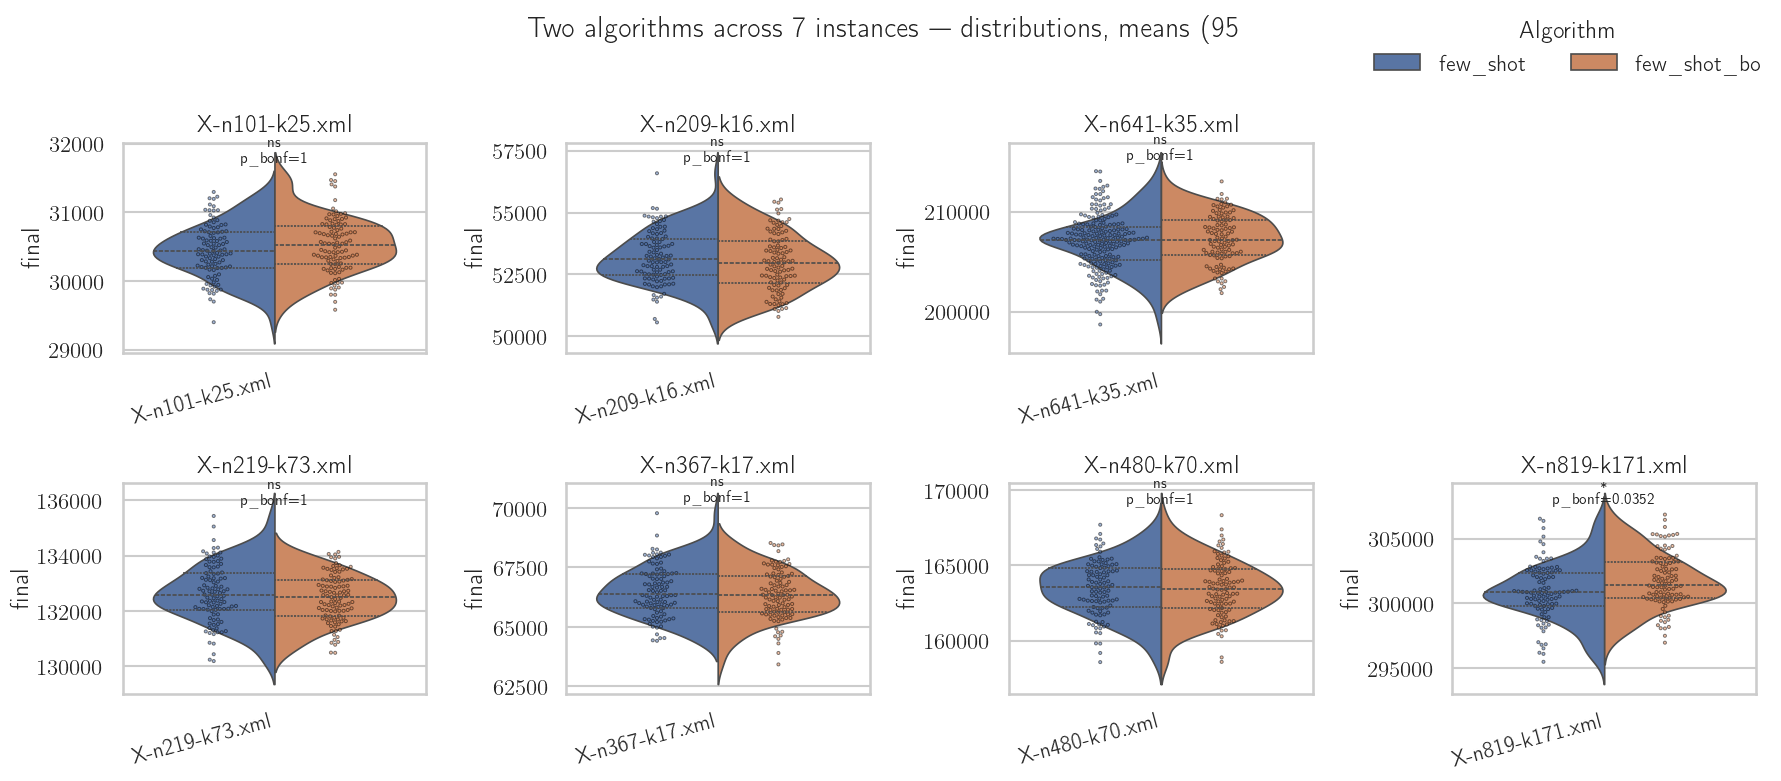

In [ ]:
def get_label_name(algorithm_name):
    if algorithm_name == "few_shot":
        return r"Адаптация $\theta$ нейронной сетью"
    if algorithm_name == "few_shot_bo":
        return 

# === CONFIG =================================================================
instance_names = [
    "X-n101-k25.xml",
    "X-n209-k16.xml",
    "X-n641-k35.xml",
    "X-n219-k73.xml",
    "X-n367-k17.xml",
    "X-n480-k70.xml",
    "X-n819-k171.xml",
]
algo_a = "few_shot"
algo_b = "few_shot_bo"

# === LIBS ===================================================================
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats                               # Welch t-test (equal_var=False)
from statsmodels.stats.multitest import multipletests  # Bonferroni

# === HELPERS =================================================================
def cohen_d_independent(x: np.ndarray, y: np.ndarray) -> float:
    nx, ny = len(x), len(y)
    sx, sy = x.std(ddof=1), y.std(ddof=1)
    s_pooled = np.sqrt(((nx - 1) * sx**2 + (ny - 1) * sy**2) / (nx + ny - 2))
    if s_pooled == 0:
        return 0.0
    return (x.mean() - y.mean()) / s_pooled

def p_to_stars(p: float) -> str:
    if p < 1e-4: return "****"
    if p < 1e-3: return "***"
    if p < 1e-2: return "**"
    if p < 5e-2: return "*"
    return "ns"

# === LOAD DATA ===============================================================
rows = []
for inst in instance_names:
    for alg in (algo_a, algo_b):
        vals = get_finals(inst, alg)  # np.array shape (100,)
        rows.extend([{"instance": inst, "algorithm": alg, "final": float(v)} for v in vals])
df = pd.DataFrame(rows)

# === STATS (RAW SCALE): Welch + Bonferroni ==================================
stats_rows = []
for inst in instance_names:
    a = df[(df["instance"] == inst) & (df["algorithm"] == algo_a)]["final"].to_numpy()
    b = df[(df["instance"] == inst) & (df["algorithm"] == algo_b)]["final"].to_numpy()
    t_stat, p_val = stats.ttest_ind(a, b, equal_var=False)  # Welch
    d = cohen_d_independent(a, b)
    stats_rows.append({
        "instance": inst,
        "mean_A": a.mean(), "mean_B": b.mean(),
        "std_A": a.std(ddof=1), "std_B": b.std(ddof=1),
        "t": t_stat, "p": p_val, "cohens_d_(A_minus_B)": d
    })
stats_df = pd.DataFrame(stats_rows)

rej, p_bonf, _, _ = multipletests(stats_df["p"].to_numpy(), alpha=0.05, method="bonferroni")
stats_df["p_bonf"] = p_bonf
stats_df["reject@Bonferroni=0.05"] = rej

print("\n=== Welch t-tests per instance (Bonferroni-corrected) ===")
print(stats_df.to_string(index=False))

# === PLOTTING: 7 subplots, grid (2 rows x 4 cols); top row uses 3 axes ======
# sns.set_theme(context="talk", style="whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 8), sharey=False)
axes = np.array(axes)

# мы оставим axes[0,3] пустым
axes[0, 3].set_visible(False)

# для единой легенды соберём хэндлы на первом сабплоте
legend_handles = legend_labels = None

for idx, inst in enumerate(instance_names):
    r = 0 if idx < 3 else 1
    c = idx if idx < 3 else (idx - 3)
    ax = axes[r, c]

    sub = df[df["instance"] == inst]

    # --- split-violin
    sns.violinplot(
        data=sub, x="instance", y="final", hue="algorithm",
        split=True, inner="quart", linewidth=1.2, ax=ax
    )

    # --- swarm (понижаем слой и добавляем обводку)
    sns.swarmplot(
        data=sub, x="instance", y="final", hue="algorithm",
        dodge=True, size=2.2, alpha=0.5,
        edgecolor="black", linewidth=0.7,
        ax=ax, legend=False, zorder=1.5
    )

    # Заголовок сабплота и подписи осей
    ax.set_title(inst, pad=8)
    ax.set_xlabel("")

    # Вместо set_xticklabels(...) — корректный поворот/выравнивание меток
    ax.tick_params(axis="x", labelrotation=15)      # поворот без FixedFormatter
    plt.setp(ax.get_xticklabels(), ha="right")      # выравнивание по правому краю

    # Сохраним легенду с первого сабплота, затем удалим локальные легенды
    if legend_handles is None:
        legend_handles, legend_labels = ax.get_legend_handles_labels()
    if ax.get_legend() is not None:
        ax.get_legend().remove()

    # Аннотация значимости (Bonferroni-скорректированный p)
    p_row = stats_df[stats_df["instance"] == inst].iloc[0]
    y_max = sub["final"].max()
    y_min = sub["final"].min()
    y_pad = 0.05 * (y_max - y_min if y_max > y_min else 1.0)
    star = p_to_stars(p_row["p_bonf"])
    ax.text(0, y_max + y_pad, f"{star}\np_bonf={p_row['p_bonf']:.3g}",
            ha="center", va="bottom", fontsize=11)

# Общая легенда по фигуре
if legend_handles is not None:
    # берём только два первых элемента (от скрипок), чтобы не дублировать
    fig.legend(legend_handles[:2], legend_labels[:2],
               title="Algorithm", frameon=True, ncol=2, loc="upper right")

fig.suptitle("Two algorithms across 7 instances — distributions, means (95% CI) & Bonferroni tests", y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.show()
fig.savefig("../outputs/figures/ablation-stats.pdf")

# === (OPTIONAL) Табличная сводка — можно сохранить для статьи/отчёта ========
# stats_df.to_csv("welch_bonf_summary.csv", index=False)


### Table

In [12]:
import numpy as np
import pandas as pd
from typing import Dict, List, Callable, Optional

# ---- Настройки --------------------------------------------------------------
lower_is_better = True  # если нужно наоборот — поставь False
fmt = "{:.3g}"  # формат чисел в таблице
add_robust_cols = True  # True => добавим Median, IQR, TrimmedMean10
trim_alpha = 0.10  # доля усечения для trimmed mean


# Маппер подписей алгоритмов (можно расширять)
def get_label_name(algorithm_name):
    if algorithm_name == "few_shot":
        return r"Адаптация $\theta$ нейронной сетью"
    if algorithm_name == "theta_control":
        return r"Адаптация $\theta$ нейронной сетью"
    if algorithm_name == "descent":
        return "Cинхронный спуск"
    if algorithm_name == "theta_schedule_linear":
        return r"Линейное уменьшение $\theta \gets \br{100, \ldots, 1}$"
    if algorithm_name == "theta_fixed_1":
        return r"Фиксированное $\theta=1$"
    if algorithm_name == "theta_fixed_10":
        return r"Фиксированное $\theta=10$"
    if algorithm_name == "theta_voting":
        return r"Адаптация $\theta$ голосованием"
    if algorithm_name == "theta_voting_scaled":
        return r"Адаптация $\theta$ масштабированным голосованием"
    if algorithm_name == "theta_one_fifth":
        return r"Адаптация $\theta$ правилом $1/5$"


def _label_for_table(name: str) -> str:
    # Без перевода строки и с экранированием символов LaTeX
    safe = get_label_name(name).replace("\\\\", " ").replace("_", r"\_")
    return safe


# ---- Базовые статистики -----------------------------------------------------
def _q(arr: np.ndarray, q: float) -> float:
    # Явно зададим метод вычисления квантилей для воспроизводимости
    return float(np.quantile(arr, q, method="linear"))


def _trimmed_mean(x: np.ndarray, alpha: float = 0.10) -> float:
    x = np.sort(np.asarray(x))
    n = len(x)
    k = int(np.floor(alpha * n))
    if 2 * k >= n:
        return float(np.mean(x))  # на всякий случай
    return float(np.mean(x[k : n - k]))


def summarize(vals: np.ndarray) -> Dict[str, float]:
    vals = np.asarray(vals, dtype=float)
    return {
        "mean": float(np.mean(vals)),
        "std": float(np.std(vals, ddof=1)),
        "q1": _q(vals, 0.25),
        "q3": _q(vals, 0.75),
        "median": float(np.median(vals)),
        "iqr": _q(vals, 0.75) - _q(vals, 0.25),
        "tmean10": _trimmed_mean(vals, alpha=trim_alpha),
    }


# ---- Подготовка таблицы -----------------------------------------------------
def build_summary_table(
    instance_names: List[str],
    algorithm_names: List[str],
) -> pd.DataFrame:
    rows = []
    for inst in instance_names:
        for alg in algorithm_names:
            vals = get_finals(inst, alg)  # <- твоя функция: np.array shape (100,)
            s = summarize(vals)
            row = {
                "instance": inst,
                "algorithm": alg,
                "mean": s["mean"],
                "std": s["std"],
                "q1": s["q1"],
                "q3": s["q3"],
                # доп. поля (могут не попасть в LaTeX, если отключишь add_robust_cols)
                "median": s["median"],
                "iqr": s["iqr"],
                "tmean10": s["tmean10"],
            }
            rows.append(row)
    df = pd.DataFrame(rows)

    # Флаг "лучший" по задаче — по медиане (устойчивее) с тай-брейком по mean.
    def _rank_key(g):
        # lower_is_better управляет направлением
        sign = 1.0 if lower_is_better else -1.0
        return g.assign(
            _score_primary=sign * g["median"],
            _score_tiebreak=sign * g["mean"],
        ).sort_values(["_score_primary", "_score_tiebreak"], ascending=True)

    best_mask = []
    for inst, g in df.groupby("instance", sort=False):
        gg = _rank_key(g)
        best_alg = gg.iloc[0]["algorithm"]
        best_mask.append((df["instance"] == inst) & (df["algorithm"] == best_alg))
    df["is_best"] = False
    if best_mask:
        df.loc[np.logical_or.reduce(best_mask), "is_best"] = True

    return df


# ---- Рендер в LaTeX tabular -------------------------------------------------
def df_to_latex_tabular(
    df: pd.DataFrame,
    add_robust_cols: bool = False,
    fmt: str = "{:.3g}",
    use_adjustbox: bool = True,        # обернуть в adjustbox
    max_width: str = r"1.0\textwidth", # только ужимать, не растягивать
    center_env: bool = True,           # обернуть в \begin{center}...\end{center}
) -> str:
    # Заголовки столбцов (на русском)
    base_headers = [r"Алгоритм", r"Среднее", r"Ст.\ откл.", r"Q1 (25\%)", r"Q3 (75\%)"]
    robust_headers = [r"Медиана", r"IQR", r"Усечённое ср.\ (10\%)"]
    headers = base_headers + (robust_headers if add_robust_cols else [])

    # Спецификация выравнивания колонок: l r r r r (+ робастные)
    base_align = ["l", "r", "r", "r", "r"]
    robust_align = ["r", "r", "r"]
    aligns = base_align + (robust_align if add_robust_cols else [])

    colspec = " | ".join(aligns)  # например: l | r | r | r | r | r | r | r

    def _row_to_tex(cells, bold=False):
        if bold:
            cells = [r"\textbf{" + c + "}" for c in cells]
        return " & ".join(cells) + r" \\"

    parts = []

    if center_env:
        parts.append(r"\begin{center}")

    if use_adjustbox:
        parts.append(r"\begin{adjustbox}{max width=" + max_width + r"}")

    parts.append(r"\begin{tabular}{" + colspec + r"}")
    parts.append(r"\hline")

    # Группировка по инстансам (задачам). Для каждой задачи — шапка + строки.
    for inst, g in df.groupby("instance", sort=False):
        # Заголовок секции задачи
        parts.append(r"\multicolumn{" + str(len(headers)) + r"}{l}{\textbf{Задача: "
                     + inst.replace("_", r"\_") + r"}} \\")
        parts.append(r"\hline")

        # Шапка колонок (повторяем для каждой задачи)
        parts.append(_row_to_tex(headers))
        parts.append(r"\hline")

        # Отсортируем так, чтобы «лучший» шёл первым
        g = g.sort_values(by=["median", "mean"], ascending=[lower_is_better, lower_is_better])

        for _, row in g.iterrows():
            # имя алгоритма (экранируем спецсимволы, переносы — убираем)
            name = _label_for_table(row["algorithm"])

            values = [
                fmt.format(row["mean"]),
                fmt.format(row["std"]),
                fmt.format(row["q1"]),
                fmt.format(row["q3"]),
            ]
            if add_robust_cols:
                values += [
                    fmt.format(row["median"]),
                    fmt.format(row["iqr"]),
                    fmt.format(row["tmean10"]),
                ]

            # первая ячейка — имя алгоритма
            cells = [name] + values

            # ЛУЧШАЯ строка — ЖИРНАЯ ЦЕЛИКОМ
            parts.append(_row_to_tex(cells, bold=bool(row["is_best"])))
        parts.append(r"\hline")

    parts.append(r"\end{tabular}")

    if use_adjustbox:
        parts.append(r"\end{adjustbox}")

    if center_env:
        parts.append(r"\end{center}")

    return "\n".join(parts)


# ---- Пример использования ---------------------------------------------------
instance_names = [
    "X-n101-k25.xml",
    "X-n209-k16.xml",
    "X-n641-k35.xml",
    "X-n219-k73.xml",
    "X-n367-k17.xml",
    "X-n480-k70.xml",
    "X-n819-k171.xml",
]

algorithm_names = [
    "few_shot",
    "theta_schedule_linear",
    "theta_fixed_1",
    "theta_fixed_10",
    "theta_voting",
    "theta_one_fifth",
]

df = build_summary_table(instance_names, algorithm_names)

latex_table = df_to_latex_tabular(
    df,
    add_robust_cols=add_robust_cols,  # True => добавит Median/IQR/TrimmedMean10
    fmt=fmt,
    # table_width="1.0\\textwidth",  # или None, если не хочешь adjustbox
)

print(latex_table)

\begin{center}
\begin{adjustbox}{max width=1.0\textwidth}
\begin{tabular}{l | r | r | r | r | r | r | r}
\hline
\multicolumn{8}{l}{\textbf{Задача: X-n101-k25.xml}} \\
\hline
Алгоритм & Среднее & Ст.\ откл. & Q1 (25\%) & Q3 (75\%) & Медиана & IQR & Усечённое ср.\ (10\%) \\
\hline
\textbf{Адаптация $\theta$ нейронной сетью} & \textbf{3.04e+04} & \textbf{387} & \textbf{3.02e+04} & \textbf{3.07e+04} & \textbf{3.04e+04} & \textbf{516} & \textbf{3.04e+04} \\
Адаптация $\theta$ правилом $1/5$ & 3.05e+04 & 413 & 3.03e+04 & 3.08e+04 & 3.05e+04 & 464 & 3.05e+04 \\
Фиксированное $\theta=1$ & 3.08e+04 & 423 & 3.05e+04 & 3.11e+04 & 3.08e+04 & 619 & 3.08e+04 \\
Адаптация $\theta$ голосованием & 3.25e+04 & 754 & 3.2e+04 & 3.3e+04 & 3.24e+04 & 1.04e+03 & 3.25e+04 \\
Фиксированное $\theta=10$ & 3.42e+04 & 561 & 3.39e+04 & 3.46e+04 & 3.42e+04 & 737 & 3.42e+04 \\
Линейное уменьшение $\theta \gets \br{100, \ldots, 1}$ & 3.71e+04 & 673 & 3.65e+04 & 3.76e+04 & 3.71e+04 & 1e+03 & 3.71e+04 \\
\hline
\multicol

### Timings

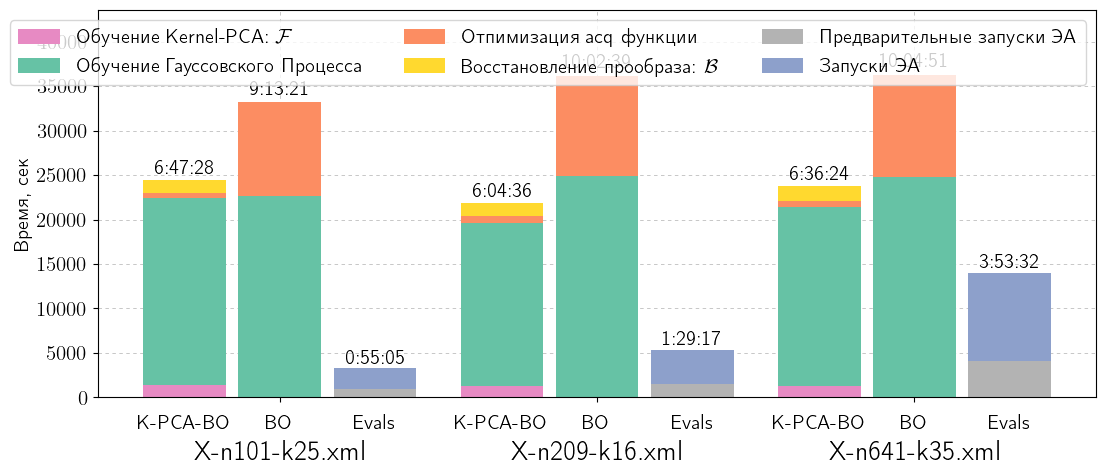

In [46]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Patch
from matplotlib.transforms import offset_copy

from FewShotCVRP.utils.plots import good_plt_config
good_plt_config()

text_fontsize = 15

# --- helpers -----------------------------------------------------------------
def fmt_hms(seconds: float) -> str:
    """Format seconds -> h:mm:ss (rounded to nearest second)."""
    sec = int(round(float(seconds)))
    h = sec // 3600
    m = (sec % 3600) // 60
    s = sec % 60
    return f"{h}:{m:02d}:{s:02d}"

def parse_hms_mixed(s: str) -> int:
    """
    Parse '20h59m23s' or '21:14:37' -> seconds.
    """
    s = s.strip()
    if "h" in s:  # like 20h59m23s
        h = int(s.split("h")[0])
        rest = s.split("h")[1]
        m = int(rest.split("m")[0])
        sec = int(rest.split("m")[1].rstrip("s"))
        return h * 3600 + m * 60 + sec
    # like 21:14:37
    h, m, sec = map(int, s.split(":"))
    return h * 3600 + m * 60 + sec

def diff_seconds(start: str, finish: str) -> int:
    a = parse_hms_mixed(start)
    b = parse_hms_mixed(finish)
    if b < a:  # на случай перехода через полночь
        b += 24 * 3600
    return b - a


def get_label_name(label):
    if label == "fit_kpca":
        return r"Обучение Kernel-PCA: $\mathcal{F}$"
    if label ==  "fit_gp":
        return r"Обучение Гауссовского Процесса"
    if label == "argmax_acq":
        return r"Отпимизация acq функции"
    if label == "find_preimages":
        return r"Восстановление прообраза: $\mathcal{B}$"
    if label == "precompute":
        return r"Предварительные запуски ЭА"
    if label == "evaluate_objective":
        return r"Запуски ЭА"


# --- input -------------------------------------------------------------------
bo_csv = Path("bo_timing_by_step.csv")
kp_csv = Path("kpcabo_timing_by_step.csv")

df_bo = pd.read_csv(bo_csv)
df_kp = pd.read_csv(kp_csv)

# --- columns to stack --------------------------------------------------------
bo_cols_stack = ["fit_gp", "argmax_acq"]               # evaluate_objective -> отдельный бар (справа)
kp_cols_stack = ["fit_kpca", "fit_gp", "argmax_acq", "find_preimages"]

# --- aggregate by instance ---------------------------------------------------
def sum_by_instance(df: pd.DataFrame, cols) -> pd.DataFrame:
    out = df.groupby("instance", as_index=False)[cols].sum(min_count=1)
    out[cols] = out[cols].astype(float).fillna(0.0)
    return out

tot_bo_stack = sum_by_instance(df_bo, bo_cols_stack)
tot_kp_stack = sum_by_instance(df_kp, kp_cols_stack)

tot_bo_eval = sum_by_instance(df_bo, ["evaluate_objective"]).rename(columns={"evaluate_objective": "eval_bo"})
tot_kp_eval = sum_by_instance(df_kp, ["evaluate_objective"]).rename(columns={"evaluate_objective": "eval_kp"})

# --- consistent instance order ----------------------------------------------
order = list(dict.fromkeys(list(df_bo["instance"]) + list(df_kp["instance"])))

def reorder(df, cols_keep):
    return df.set_index("instance").reindex(order).reset_index()[["instance"] + cols_keep]

tot_bo_stack = reorder(tot_bo_stack, bo_cols_stack)
tot_kp_stack = reorder(tot_kp_stack, kp_cols_stack)
tot_eval = (tot_bo_eval.merge(tot_kp_eval, on="instance", how="outer")
                     .set_index("instance").reindex(order).reset_index())
tot_eval[["eval_bo", "eval_kp"]] = tot_eval[["eval_bo", "eval_kp"]].fillna(0.0)

# --- evaluate bar: mean (можно вернуть yerr при необходимости) --------------
eval_mean = (tot_eval[["eval_bo", "eval_kp"]].mean(axis=1)).to_numpy()
# eval_diff = np.abs(tot_eval["eval_bo"] - tot_eval["eval_kp"]).to_numpy()
# eval_yerr = 0.5 * eval_diff

# --- DoE durations (слева направо, под каждый Evals-бар) --------------------
# ВРЕМЕНА ИЗ ТВОЕГО СООБЩЕНИЯ (в порядке слева направо):
t_doe_1 = "start: 20h59m23s, finish: 21:14:37"
t_doe_2 = "start: 21h14m37s, finish: 21:40:10"
t_doe_3 = "start: 21h40m10s, finish: 22:48:21"

def parse_doe_pair(s: str) -> int:
    # expected format like: 'start: 20h59m23s, finish: 21:14:37'
    left = s.split("start:")[1].strip()
    start_str, right = left.split(",", 1)
    finish_str = right.split("finish:")[1].strip()
    return diff_seconds(start_str, finish_str)

doe_seconds_list = [parse_doe_pair(t_doe_1),
                    parse_doe_pair(t_doe_2),
                    parse_doe_pair(t_doe_3)]
# Преобразуем к длине n (если инстансов больше/меньше трёх)
instances = order
n = len(instances)
doe_seconds = np.zeros(n, dtype=float)
for i, val in enumerate(doe_seconds_list[:n]):
    doe_seconds[i] = float(val)

# --- palette -----------------------------------------------------------------
colors = {
    "fit_kpca": "#E78AC3",         # pink
    "fit_gp": "#66C2A5",           # greenish
    "argmax_acq": "#FC8D62",       # orange
    "find_preimages": "#FFD92F",   # yellow
    "evaluate_objective": "#8DA0CB", # blue (верхняя часть правого бара)
    "precompute": "#B3B3B3",       # gray (нижняя часть правого бара)
}

# --- layout for side-by-side bars -------------------------------------------
x = np.arange(n)
width = 0.26   # ширина одного бара
gap   = 0.04   # зазор между барами внутри тройки

# KPCA-BO слева, BO посередине, Evals справа (как ты просил ранее)
x_kp = x - (width + gap)   # left:  KPCA-BO (stacked)
x_bo = x                   # mid:   BO (stacked)
x_ev = x + (width + gap)   # right: Evals (stacked DoE + eval)

# --- plot --------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(max(12, n*2.2), 5))

def stacked_bar(ax, x_pos, df_rowwise, components, width):
    bottoms = np.zeros(len(x_pos), dtype=float)
    for comp in components:
        heights = df_rowwise[comp].to_numpy()
        ax.bar(x_pos, heights, width, bottom=bottoms, color=colors[comp], label=comp)
        bottoms += heights
    return bottoms

# LEFT: KPCA-BO (stacked)
kp_totals = stacked_bar(ax, x_kp, tot_kp_stack, kp_cols_stack, width)

# MIDDLE: BO (stacked)
bo_totals = stacked_bar(ax, x_bo, tot_bo_stack, bo_cols_stack, width)

# RIGHT: Evals (stacked: DoE (серый) + evaluate_objective (синий))
# нижний сегмент — предподсчёт
ax.bar(x_ev, doe_seconds, width, color=colors["precompute"], label="precompute")
# верхний сегмент — суммарная оценка целевой функции (mean)
ax.bar(x_ev, eval_mean, width, bottom=doe_seconds, color=colors["evaluate_objective"], label="evaluate_objective")

# Axes labels & ticks
ax.set_xticks(x)
ax.set_xticklabels(instances, rotation=0, ha="center", fontsize=20)
ax.tick_params(axis="x", pad=27)  # побольше отступ под названия задач
# ax.set_xlabel("Инстанс")
ax.set_ylabel("Время, сек")
ax.grid(True, axis="y")
ax.set_axisbelow(True)

# Legend (flat)
legend_order = ["fit_kpca", "fit_gp", "argmax_acq", "find_preimages", "precompute", "evaluate_objective"]
handles = [Patch(facecolor=colors[c], edgecolor="none") for c in legend_order]
labels_local = [get_label_name(c) for c in legend_order]

ax.legend(
    handles,
    labels_local,
    frameon=True,
    ncol=3,
    loc="upper right",
)

# --- room on top so labels fit ----------------------------------------------
ymax = max(
    kp_totals.max() if len(kp_totals) else 0,
    bo_totals.max() if len(bo_totals) else 0,
    (doe_seconds + eval_mean).max() if len(eval_mean) else 0,
)
ax.set_ylim(0, ymax * 1.20)  # чуть больше запаса сверху

# --- annotate totals above bars in h:mm:ss -----------------------------------
for xi, s in zip(x_kp, kp_totals):
    ax.text(xi, s * 1.01, fmt_hms(s), ha="center", va="bottom", fontsize=text_fontsize)
for xi, s in zip(x_bo, bo_totals):
    ax.text(xi, s * 1.01, fmt_hms(s), ha="center", va="bottom", fontsize=text_fontsize)
for xi, s in zip(x_ev, doe_seconds + eval_mean):  # суммарное DoE+Eval
    ax.text(xi, s * 1.01, fmt_hms(s), ha="center", va="bottom", fontsize=text_fontsize)

# --- labels under X-axis with indentation (KPCA-BO / BO / Evals) -------------
text_trans = offset_copy(ax.get_xaxis_transform(), fig=fig, x=0, y=-12, units='points')
for i in range(n):
    ax.text(x_kp[i], 0, "K-PCA-BO", ha="center", va="top", fontsize=text_fontsize, transform=text_trans)
    ax.text(x_bo[i], 0, "BO",       ha="center", va="top", fontsize=text_fontsize, transform=text_trans)
    ax.text(x_ev[i], 0, "Evals",    ha="center", va="top", fontsize=text_fontsize, transform=text_trans)

# немного увеличим нижнее поле, чтобы подписи не обрезались
plt.subplots_adjust(bottom=0.26)
fig.tight_layout()

# save
# out_png = "../outputs/figures/bo_vs_kpcabo_plus_eval_bars_with_doe.png"
out_pdf = "../outputs/figures/bo_vs_kpcabo_plus_eval_bars_with_doe.pdf"
# fig.savefig(out_png, dpi=300, bbox_inches="tight")
fig.savefig(out_pdf, bbox_inches="tight")
# plt.show()

# print(f"Saved: {out_png} and {out_pdf}")
